In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [11]:
df = pd.read_parquet('/Users/ye/Desktop/ACC/df.parquet', engine='pyarrow')
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
Y = df['proc'].values
X = df.drop(columns=['proc']).values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(Y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [66]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_features, hidden_layers):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(input_features, hidden_layers[0])
        self.layer1 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.layer2 = nn.Linear(hidden_layers[1], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x


# Do the Quantization

In [67]:
batch = 1000
num_epochs = 200
hidden_layers = [32,16]


In [68]:
X.shape[1]

142

In [94]:
# create the model instance
models = BinaryClassificationModel(input_features=X.shape[1], hidden_layers=[64, 32])
# create the quantized model instance
model_quant = torch.ao.quantization.quantize_dynamic(
    models,
    {nn.Linear}, # the sets f layers to dynamically qunatize
    dtype=torch.qint8 # the target dtype for qunatized weights
    )

In [95]:
print('Here is the floating point version of this module:')
print(models)
print('')
print('and now the quantized version:')
print(model_quant)

Here is the floating point version of this module:
BinaryClassificationModel(
  (layer0): Linear(in_features=142, out_features=64, bias=True)
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

and now the quantized version:
BinaryClassificationModel(
  (layer0): DynamicQuantizedLinear(in_features=142, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer1): DynamicQuantizedLinear(in_features=64, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer2): DynamicQuantizedLinear(in_features=32, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (sigmoid): Sigmoid()
)


# Look at the Model Size

In [96]:
import os
def model_size(model, label=''):
    """
    Calculate and print the size of a PyTorch model's parameters in kilobytes (KB).
    
    Parameters:
    - model: The PyTorch model whose size is to be calculated.
    - label: An optional label to identify the model in the output (default is an empty string).
    
    Returns:
    - The size of the model in bytes.
    """
    torch.save(model.state_dict(), "mymodel.p")
    # size reflects the amount of storage needed to save the model's parameters.
    size = os.path.getsize("mymodel.p")
    print("model: ",label,' \t','Size (KB):', size/1024) # the bytes are divide by 1024 to convert to kilobytes in binary terms
    os.remove("mymodel.p")
    return size

# compare the size
f = model_size(models, "fp32") # size of the full precision model
q = model_size(model_quant, "int8") # size of the quantized model
print("{0:.3f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 45.8349609375
model:  int8  	 Size (KB): 15.0634765625
3.043 times smaller


# Look at the Latency

In [97]:
X.shape[1]

142

In [102]:
batch_size = 64  # batch size 
input_features = X.shape[1]  #  number of input features 
inputs = torch.randn(batch_size, input_features)

In [101]:
%timeit -r 3 -n 1000 models.forward(inputs)

164 µs ± 3.98 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [75]:
print("Floating point FP32")
inputs = X.shape
%timeit model.forward(inputs)



Floating point FP32


TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (int, int)!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (int, int)!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [26]:
import torch
import torchvision.models as models
import torch.quantization

In [36]:
# model = models.resnet18(pretrained=True)
# model.eval() 

In [37]:
# set the quantisation configuration for the model
models.qconfig = torch.quantization.get_default_qconfig('qnnpack')
# prepare the model 
model_prepared = torch.quantization.prepare(models, inplace=False)


TypeError: cannot pickle 'module' object

In [30]:
# Convert the prepared model to a quantized model
model_quantized = torch.quantization.convert(model_prepared, inplace=False)


In [33]:
model_quantized

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
df.shape

(60000, 143)

In [31]:
# the function for model training
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    """
    Train a given model.

    Parameters:
    - model: The model to be trained.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - num_epochs: Number of epochs to train the model.

    Returns:
    - losses: List of loss values per epoch.
    """
    losses = []  # To store loss at each epoch
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    return losses

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_quntized = train_model(model_quantized, train_loader, criterion, optimizer, num_epochs=200)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 142]

In [9]:

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

losses = []
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
y_pre = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pre.append(predicted)
accuracy = correct / total
print(f'Accuracy: {accuracy}')

Epoch 1, Loss: 0.9125992059707642
Epoch 2, Loss: 0.6995591521263123
Epoch 3, Loss: 2.1680243015289307
Epoch 4, Loss: 0.4269472360610962
Epoch 5, Loss: 2.256359338760376
Epoch 6, Loss: 0.5562547445297241
Epoch 7, Loss: 0.5179117918014526
Epoch 8, Loss: 0.5085573792457581
Epoch 9, Loss: 0.6116062998771667
Epoch 10, Loss: 0.4852801561355591
Epoch 11, Loss: 0.46259045600891113
Epoch 12, Loss: 0.5649406909942627
Epoch 13, Loss: 0.5077359676361084
Epoch 14, Loss: 0.4745936095714569
Epoch 15, Loss: 0.590796709060669
Epoch 16, Loss: 0.6771931648254395
Epoch 17, Loss: 0.5197178721427917
Epoch 18, Loss: 0.6066542863845825
Epoch 19, Loss: 0.7971432209014893
Epoch 20, Loss: 2.167032480239868
Epoch 21, Loss: 0.5671040415763855
Epoch 22, Loss: 0.4715695083141327
Epoch 23, Loss: 0.6161985993385315
Epoch 24, Loss: 0.610099732875824
Epoch 25, Loss: 0.5230613350868225
Epoch 26, Loss: 0.4782036244869232
Epoch 27, Loss: 0.48619306087493896
Epoch 28, Loss: 2.090264081954956
Epoch 29, Loss: 0.63625872135162

In [25]:
model = BinaryClassificationModel().eval()

# Specify the quantization configuration for the model
# You might need to experiment with different quantization configurations
model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

# Prepare the model for static quantization
model_prepared = torch.quantization.prepare(model, inplace=False)


In [26]:
# Calibrate the model
# Assuming 'calibration_dataloader' is a DataLoader object for your calibration dataset
with torch.no_grad():
    for inputs, _ in test_loader:
        model_prepared(inputs)

- torch.quantization.get_default_qconfig: This function retrieves a default quantization configuration object. The configuration includes settings for quantizing weights and activations, such as the quantization method (affine or symmetric), the number of bits to use for quantization (typically 8-bit), and the quantization range or scale.
- 'fbgemm': This string argument specifies the backend to use for quantized tensor operations. FBGEMM is designed for x86 architectures and is optimized for servers. It supports fast, efficient operations on quantized matrices, making it suitable for deploying quantized models on server environments where performance is critical.
- Resulting qconfig: The returned configuration is assigned to model.qconfig, applying these quantization parameters to the model during preparation (torch.quantization.prepare) and conversion (torch.quantization.convert) steps. Essentially, it instructs PyTorch on how to quantize the model's weights and activations using the FBGEMM backend, aiming for a good balance between performance and accuracy.


In [27]:
model_quantized = torch.quantization.convert(model_prepared, inplace=False)

In [29]:
model

BinaryClassificationModel(
  (layer0): Linear(in_features=142, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

- floating-point inputs have been mapped to a fixed set of integer values.
- The scale factor is used to convert the integer values back to floating-point numbers, and the zero_point represents the integer value mapped to the real number zero. 
- The qscheme indicates the quantization scheme used, which in this case is torch.per_tensor_affine, meaning each tensor is quantized using a single scale and zero_point that applies to the entire tensor.
- $q = round((x-zero\_point)/scale)$ 
   - x is the original floating-point value.
   - q is the quantized integer value.
   - scale is a scaling factor used to map the floating-point values to the quantized space.
   - zero_point is used to ensure zero is accurately represented after quantization and to adjust for the range of the quantized data.
- Clamping: $q=clamp(q, q\_min,q\_max)$ the quantized value q is clamped to the nearest value within the allowed range
- Inverse Quantization Process: the inverse quantization process maps the quantized integer value q back to a floating-point approximation $\hat{x}$: $\hat{x} = q x scale + zero\_point$


In [28]:
model_quantized 

BinaryClassificationModel(
  (layer0): QuantizedLinear(in_features=142, out_features=32, scale=10.270036697387695, zero_point=117, qscheme=torch.per_tensor_affine)
  (layer1): QuantizedLinear(in_features=32, out_features=16, scale=3.8025708198547363, zero_point=129, qscheme=torch.per_tensor_affine)
  (layer2): QuantizedLinear(in_features=16, out_features=1, scale=0.6736122965812683, zero_point=0, qscheme=torch.per_tensor_affine)
  (sigmoid): Sigmoid()
)

In [19]:
from sklearn.metrics import roc_auc_score

def AUC(model, test_loader):
    model.eval()
    
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            output = model(data)
            # Dequantize output if the model is quantized
            if hasattr(output, 'dequantize'):
                output = output.dequantize()
            all_outputs.append(output[:, 1])  # Adjust indexing based on your output tensor structure
            all_targets.append(targets)
            
    all_outputs = torch.cat(all_outputs).numpy()  # Convert to numpy for roc_auc_score
    all_targets = torch.cat(all_targets).numpy()

    # Calculate AUC
    auc_score = roc_auc_score(all_targets, all_outputs)
    
    return auc_score

In [21]:
# Evaluate the quantized model
# Ensure to write or use an existing function to evaluate your model's performance
AUC(model_quantized, test_loader)


NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [MPS, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

MPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:39 [backend fallback]
QuantizedCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/qlinear.cpp:990 [kernel]
BackendSelect: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:30 [backend fallback]
AutogradCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:34 [backend fallback]
AutogradCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:42 [backend fallback]
AutogradXLA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:46 [backend fallback]
AutogradMPS: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:54 [backend fallback]
AutogradXPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:38 [backend fallback]
AutogradHPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradLazy: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:50 [backend fallback]
AutogradMeta: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:58 [backend fallback]
Tracer: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:487 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]


In [ ]:
# qunatisation aware training 

In [10]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.5


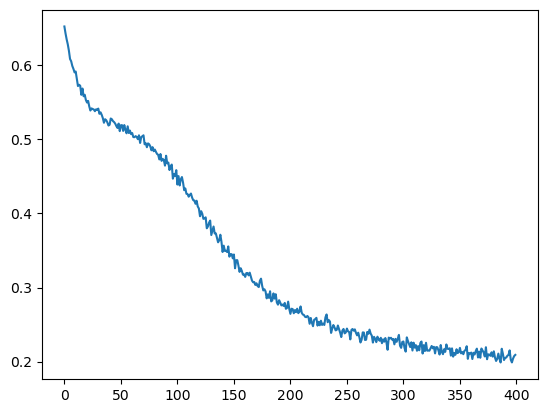

In [111]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i].detach())
plt.plot(lss)

In [100]:
# memeory calcualtion
# 

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y, predicted)
print(f'AUC = {auc}')